# Only Color Info

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from matplotlib.colors import LogNorm
from sklearn.metrics import mean_squared_error

# ''LOOK AT YOUR DATA!'' - Gautham

In [3]:
df_photo = pd.read_csv('./data/stripe82candidateVar_v1.1.dat',skiprows=5, header=1,index_col=0,sep='\s+')

In [4]:
colnames = ['ID','Priority','Flags','Teff','eTeff','NTeff','logg','elogg','Nlogg','Z','eZ','NZ']
df_spec = pd.read_csv('./data/t3.txt',sep='\s+',skiprows=26,header=None,index_col=0,names=colnames)

In [5]:
#Combine both datasets 
df = pd.merge(df_spec, df_photo, on='ID',how='left')

In [6]:
df.head()

,Priority,Flags,Teff,eTeff,NTeff,logg,elogg,Nlogg,Z,eZ,...,ri,iz,gN,gAmpl,rN,rAmpl,iN,iAmpl,zQSO,MiQSO
ID,,,,,,,,,,,,,,,,,,,,,
4172970,4.0,nnnnn,5499.7,94.7,7,3.94,0.18,6,0.01,0.12,...,0.13,0.07,29,0.197,27,0.156,27,0.231,-9.9,-9.9
4583821,5.0,Nnnnn,4487.8,120.3,3,4.19,0.26,2,-0.95,0.08,...,0.30,0.16,50,0.124,49,0.106,51,0.094,-9.9,-9.9
4651452,2.0,NnBnX,-9999.0,-9999.0,0,-9999.00,-9999.00,0,-9999.00,-9999.00,...,-0.06,0.26,36,0.505,33,0.460,27,1.150,-9.9,-9.9
4777216,9.0,nnnnX,-9999.0,-9999.0,0,-9999.00,-9999.00,0,-9999.00,-9999.00,...,0.10,0.02,47,0.133,47,0.394,47,0.154,-9.9,-9.9
5302673,9.0,nnnnn,5986.7,161.8,4,3.93,0.79,2,-0.76,0.09,...,0.13,-0.05,36,0.332,33,0.175,39,0.253,-9.9,-9.9


In [7]:
df_nonan = df[df['Teff'] != -9999.0]

Text(0, 0.5, 'Z')

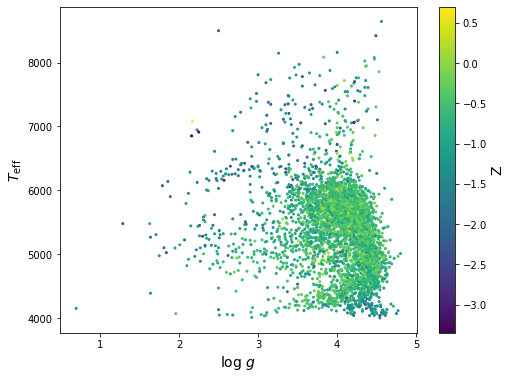

In [8]:
fig = plt.figure(1,figsize=(8,6))
plt.scatter(df_nonan['logg'],df_nonan['Teff'],c=df_nonan['Z'],cmap='viridis', s=4)
plt.xlabel(r'$\log\ g$', fontsize=14)
plt.ylabel(r'$T_{\rm{eff}}$', fontsize=14)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Z', fontsize=14)

In [9]:
df.columns

Index(['Priority', 'Flags', 'Teff', 'eTeff', 'NTeff', 'logg', 'elogg', 'Nlogg',
       'Z', 'eZ', 'NZ', 'ra', 'dec', 'P', 'r', 'ug', 'gr', 'ri', 'iz', 'gN',
       'gAmpl', 'rN', 'rAmpl', 'iN', 'iAmpl', 'zQSO', 'MiQSO'],
      dtype='object')

# Model

In [11]:
def predict(feats, parameter, epochs=100, test_size=0.25, val_split=0.15, loss_fn='mse'):
    '''
    Train NN and plot predictions for parameter ('Teff','Z','logg') using features.
    '''
        
    # Clean data
    df_nonan = df[df[parameter] != -9999.0]
    df_Y = df_nonan[parameter]
    df_X = df_nonan[feats]
    # Split into test and training set
    train_X, test_X, train_y, test_y = train_test_split(df_X, df_Y, random_state=1, test_size=test_size)
    # Print training statistics
    train_stats = train_X.describe()
    train_stats = train_stats.transpose()
    print(train_stats)
    # Normalize data
    train_X_norm = (train_X - train_stats['mean']) / train_stats['std']
    test_X_norm = (test_X - train_stats['mean']) / train_stats['std']
    # Normalize y?
    
    # Model
    model = keras.Sequential([
    keras.layers.Flatten(input_shape=(len(train_X.columns),)),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(1)
    ])
    # Optimize and train
    adm = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(optimizer='adam', loss=loss_fn,
              metrics=['mae', 'mse','msle','mape','kullback_leibler_divergence'])
    # Get training history
    print('Training with %d epochs' % epochs)
    history = model.fit(train_X_norm, train_y, epochs=epochs, batch_size=32, validation_split=val_split, verbose=0)
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    #model_temp.evaluate(test_X_norm, test_y)
    # Plot loss curve
    fig = plt.figure(1,figsize=(8,6))
    plt.plot(hist['epoch'],hist['val_loss'], lw=5, label='validation loss')
    plt.plot(hist['epoch'],hist['loss'], lw=3, label='training loss', linestyle='dashed')
    plt.legend(fontsize=20)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.show()
    
    # Plot prediction
    test_predictions = model.predict(test_X_norm).flatten()
    t_y = test_y.to_numpy()

    rmse = np.sqrt(mean_squared_error(test_y,test_predictions))
    error = np.abs(t_y-test_predictions/t_y)
    x = np.arange(np.min(test_predictions),np.max(test_predictions),0.1)
    fig = plt.figure(1,figsize=(8,6))
    plt.scatter(test_y, test_predictions,c=error,cmap='Reds', s=10)
    plt.plot(x,x,'r-')
    plt.plot()
    plt.xlabel('True Values', fontsize=14)
    plt.ylabel('Predictions', fontsize=14)
    plt.xlim(np.min(test_predictions),np.max(test_predictions))
    plt.ylim(np.min(test_predictions),np.max(test_predictions))
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('error', fontsize=14)
    plt.text(0.5,0.2,'RMSE=%0.2f'%rmse,transform=plt.gca().transAxes,fontsize=20)
    plt.show()

# Neural Network - Teff

     count      mean       std   min   25%   50%   75%   max
ug  2970.0  1.607599  0.507682 -0.05  1.19  1.48  1.97  3.19
gr  2970.0  0.605354  0.282562 -0.23  0.41  0.54  0.77  1.41
ri  2970.0  0.213303  0.137128 -0.27  0.13  0.18  0.27  1.22
iz  2970.0  0.080121  0.098160 -0.29  0.01  0.06  0.13  0.71
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Training with 100 epochs


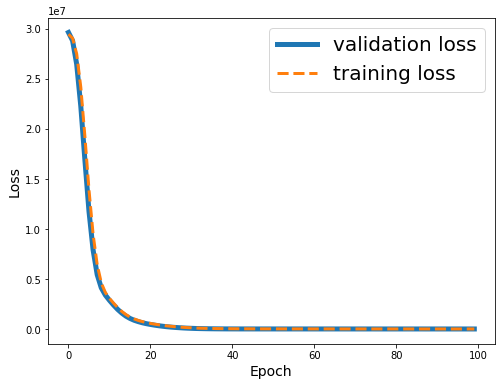

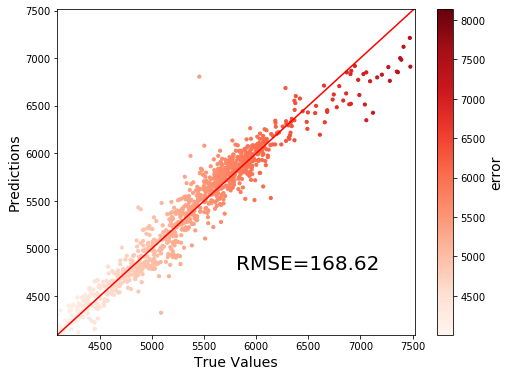

In [12]:
predict(feats=['ug','gr','ri','iz'], parameter='Teff')

# Neural Network - g

     count      mean       std   min   25%   50%   75%   max
ug  2970.0  1.607599  0.507682 -0.05  1.19  1.48  1.97  3.19
gr  2970.0  0.605354  0.282562 -0.23  0.41  0.54  0.77  1.41
ri  2970.0  0.213303  0.137128 -0.27  0.13  0.18  0.27  1.22
iz  2970.0  0.080121  0.098160 -0.29  0.01  0.06  0.13  0.71
Training with 100 epochs


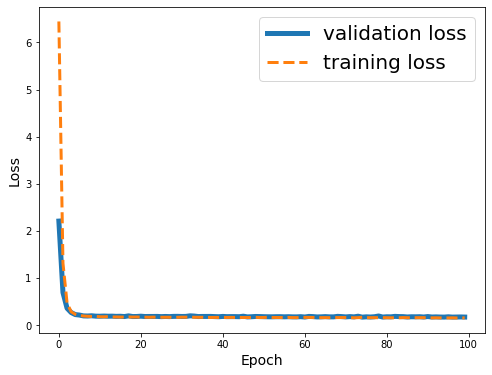

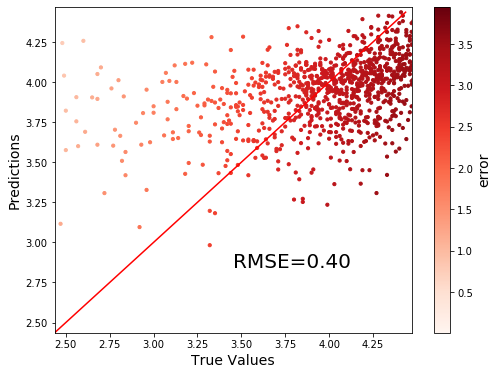

In [13]:
predict(feats=['ug','gr','ri','iz'], parameter='logg')

# Neural Net - Metallicity

     count      mean       std   min   25%   50%   75%   max
ug  2970.0  1.607599  0.507682 -0.05  1.19  1.48  1.97  3.19
gr  2970.0  0.605354  0.282562 -0.23  0.41  0.54  0.77  1.41
ri  2970.0  0.213303  0.137128 -0.27  0.13  0.18  0.27  1.22
iz  2970.0  0.080121  0.098160 -0.29  0.01  0.06  0.13  0.71
Training with 100 epochs


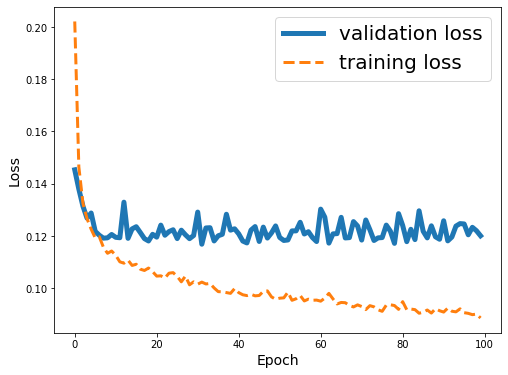

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in true_divide


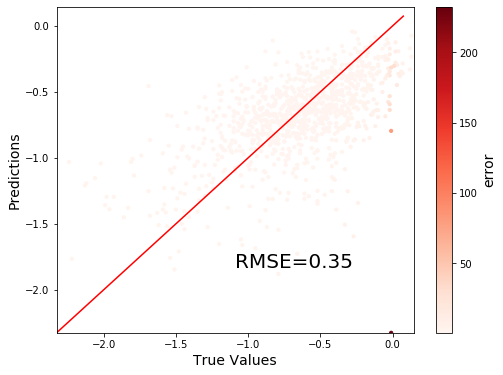

In [14]:
predict(feats=['ug','gr','ri','iz'], parameter='Z')